# Project: ML - LogisticRegression, KNN and RandomForests (Titanic)

<br>

## Questions to address:
- Predict survival from data on Titanic passengers

<br>

## Tools:
- Models: 
  - Logistic Regression
  - K-nearest neighbors
  - Random Forests  
- Feature Preparation, Selection and Engineering:
  - fill NaNs with mean or top value
  - bin data to create new categories using pd.cut()
  - extract data from text columns
  - create dummies
  - RFECV feature selection
- Model selection with GridSearchCV 
- Error Metric: accuracy_score

<br>

### load defaults

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Titanic

In [2]:
train = pd.read_csv('./data/titanic_train.csv')
holdout = pd.read_csv('./data/titanic_test.csv')

display(holdout[:2])

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


<br>

### Feature Preparation, Selection and Engineering

In [3]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_columns(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ['Age_categories', 'Fare_categories', 'Cabin_type', 'Sex']
    df = create_dummies(df, columns)
    
    return df

In [4]:
train = process_columns(train)
holdout = process_columns(holdout)

display(train.iloc[:2,:9])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599


further data exploration: create new feature, relatives

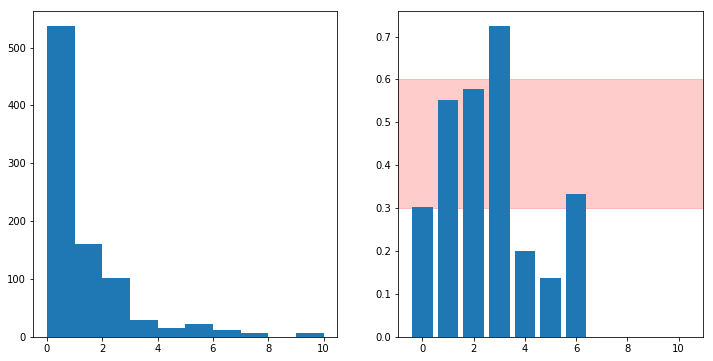

In [5]:
train['Relatives'] = train['SibSp'] + train['Parch']
holdout['Relatives'] = holdout['SibSp'] + holdout['Parch']


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.hist(train['Relatives'],10)
ax = fig.add_subplot(1,2,2)
ax.axhspan(.3, .6, alpha=0.2, color='red')
pivot_table = train.pivot_table(index='Relatives', values='Survived')
ax.bar(pivot_table.index.values, [x[0] for x in pivot_table.values])   
plt.show()

only 30% survival if no relatives, create new column: is_alone

In [6]:
def is_alone(df):
    df['isalone'] = 0
    #df['isalone'][df['Relatives']==0] = 1 
    df.loc[(df["Relatives"] == 0),"isalone"] = 1   
    return df

train = is_alone(train)
holdout = is_alone(holdout)

display(train.iloc[:3,[0,1,2,-1]])

,PassengerId,Survived,Pclass,isalone
0,1,0,3,0
1,2,1,1,0
2,3,1,3,1


<br>

### RFECV feature selection

In [7]:
def select_features(df):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
    #drop survived and ID
    all_X = df_new.drop(['Survived','PassengerId'],axis=1)
    all_y = df_new['Survived']
    
    clf = RandomForestClassifier(n_estimators=50)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns

optimized_columns = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Relatives', 'isalone']



In [10]:
def select_model(df, features_list):
    all_X = df[features_list]
    all_y = df['Survived']
    
    dicts= [ {
               "name": "LogisticRegression",
               "estimator": LogisticRegression(max_iter = 5000),
               "hyperparameters": 
                 {                
                   "solver": ["newton-cg", "lbfgs", "liblinear"]                   
                 }
             },
             {
               "name": "KNeighborsClassifier",
               "estimator": KNeighborsClassifier(),
               "hyperparameters": 
                 {
                   "n_neighbors": range(1,20,2),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "kd_tree", "brute"],
                   "p": [1,2]
                 }
             },
             {
               "name": "RandomForestClassifier",
               "estimator": RandomForestClassifier(),
               "hyperparameters": 
                 {
                   "n_estimators": [4, 6, 9],
                   "criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]                
                 }
             } ]
    
    for element in dicts:
        print(element['name'])
        print('-'*len(element['name']))
        
        model = element['estimator']
        grid = GridSearchCV(model, element['hyperparameters'], cv=10, scoring='accuracy')
        grid.fit(all_X, all_y)
        
        element['best_params'] = grid.best_params_
        element['best_score'] = grid.best_score_
        element['best_estimator'] = grid.best_estimator_   
        print("Best Parameters: {}".format(grid.best_params_))
        print("Best Score: {}\n\n".format(grid.best_score_))
       
    return dicts
        
model_dicts = select_model(train, optimized_columns)

print("model selection finished")

LogisticRegression
------------------
Best Parameters: {'solver': 'newton-cg'}
Best Score: 0.8047138047138047


KNeighborsClassifier
--------------------


/Users/BrunoHenriques/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best Score: 0.7687991021324355


RandomForestClassifier
----------------------
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
Best Score: 0.835016835016835


model selection finished


/Users/BrunoHenriques/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random forests give the best results